In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/My_model/pytorch-forecasting-master')



In [ ]:
!pip uninstall tensorflow
!pip install pytorch_lightning

In [4]:
#from pytorch_forecasting.data.examples import generate_ar_data
import matplotlib.pyplot as plt
import pandas as pd
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import pytorch_lightning as pl
from pytorch_forecasting import NegativeBinomialDistributionLoss, DeepAR
import torch
from pytorch_forecasting.data.encoders import TorchNormalizer
import numpy as np
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [5]:
df_ori = pd.read_csv('outlfow_Tamp_clstr_dem.csv')
df_175_train = df_ori['175'][:-48]
df_175_test = df_ori['175'][-48:]
len(df_175_train)



2132

In [6]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_train['series'] = np.zeros((len(df_175_train))).astype(int)
df_train['time_idx'] = np.arange(0,len(df_175_train))
df_train['value'] = df_175_train.values

df_test['series'] = np.zeros((len(df_175_test))).astype(int)
df_test['time_idx'] = np.arange(0,len(df_175_test))
df_test['value'] = df_175_test.values

data = df_train
# df.to_csv('2_freq_stoch_nbinom_dem.csv')
# df

In [7]:
# data = pd.read_csv('1_f_nbinom_train.csv')
# data

In [8]:
data["date"] = pd.Timestamp("2021-09-24") + pd.to_timedelta(data.time_idx, "H")


data['_hour_of_day'] = data["date"].dt.hour#.astype(str)
data['_day_of_week'] = data["date"].dt.dayofweek#.astype(str)
data['_day_of_month'] = data["date"].dt.day#.astype(str)
data['_day_of_year'] = data["date"].dt.dayofyear#.astype(str)
data['_week_of_year'] = data["date"].dt.weekofyear#.astype(str)
data['_month_of_year'] = data["date"].dt.month#.astype(str)
data['_year'] = data["date"].dt.year#.astype(str)

data['value'] = data['value'].astype(float)
print(type(data['value'][0])) 
print(len(data.iloc[0:-620]))



<class 'numpy.float64'>
1512


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [9]:
max_encoder_length = 168
max_prediction_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data.iloc[0:-384],
    time_idx="time_idx",
    target="value",
    # categorical_encoders={"series": NaNLabelEncoder(add_nan=True).fit(data.series), "_hour_of_day": NaNLabelEncoder(add_nan=True).fit(data._hour_of_day), \
    #    "_day_of_week": NaNLabelEncoder(add_nan=True).fit(data._day_of_week), "_day_of_month" : NaNLabelEncoder(add_nan=True).fit(data._day_of_month), "_day_of_year" : NaNLabelEncoder(add_nan=True).fit(data._day_of_year), \
    #     "_week_of_year": NaNLabelEncoder(add_nan=True).fit(data._week_of_year), "_month_of_year": NaNLabelEncoder(add_nan=True).fit(data._month_of_year) ,"_year": NaNLabelEncoder(add_nan=True).fit(data._year)},
    group_ids=["series"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["value"],
    time_varying_known_reals=["_hour_of_day","_day_of_week","_day_of_month","_day_of_year","_week_of_year","_month_of_year","_year" ],
    add_relative_time_idx=False,
    randomize_length=None,
    scalers={},
    target_normalizer=TorchNormalizer(method="identity",center=False,transformation=None )

)

In [10]:
validation = TimeSeriesDataSet.from_dataset(
    training,
    data.iloc[-384:-48],
    # predict=True,
    stop_randomization=True,
)       

In [11]:
testing = TimeSeriesDataSet.from_dataset(
    training,
    data.iloc[-384:],
    # predict=True,
    stop_randomization=True,
)       

In [12]:
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [13]:
# i=0
# for x,y in train_dataloader:
#     print('xen',x["encoder_target"])
#     print('xen_cont',x['encoder_cont'])
#     print('xde',x["decoder_target"])
#     print('xde_cont',x["decoder_cont"])
#     print('y',y[0])
#     i+=1
#     if i == 2:
#         break

In [14]:
# save datasets
training.save("training.pkl")
validation.save("validation.pkl")

In [15]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=False, mode="min")
lr_logger = LearningRateMonitor()


In [ ]:
pl.seed_everything(42)


trainer = pl.Trainer(
    max_epochs=100,
    gpus=-1,
    gradient_clip_val=0.1,
    limit_train_batches=30,
    limit_val_batches=3,
    # fast_dev_run=True,
    # logger=logger,
    # profiler=True,
    callbacks=[lr_logger, early_stop_callback],
)

deepar = DeepAR.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=320,
    dropout=0.1,
    loss=NegativeBinomialDistributionLoss(),
    log_interval=10,
    log_val_interval=3,
    # reduce_on_plateau_patience=3,
)
print(f"Number of parameters in network: {deepar.size()/1e3:.1f}k")

# find optimal learning rate
res = trainer.tuner.lr_find(
    deepar,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
deepar.hparams.learning_rate = res.suggestion()

In [17]:
trainer = pl.Trainer(
    max_epochs=100,
    gpus=-1,
    gradient_clip_val=0.1,
    limit_train_batches=30,
    limit_val_batches=3,
    # fast_dev_run=True,
    # logger=logger,
    # profiler=True,
    callbacks=[lr_logger, early_stop_callback],
)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
deepar = DeepAR.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=320,
    dropout=0.1,
    loss=NegativeBinomialDistributionLoss(),
    log_interval=10,
    log_val_interval=3,
    # reduce_on_plateau_patience=3,
)
print(f"Number of parameters in network: {deepar.size()/1e3:.1f}k")


In [19]:
# #find optimal learning rate
# deepar.hparams.log_interval = -1
# deepar.hparams.log_val_interval = -1
# trainer.limit_train_batches = 1.0
# res = trainer.tuner.lr_find(
#     deepar, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e2
# )

In [20]:
torch.set_num_threads(10)
trainer.fit(
    deepar,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                             | Params
----------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0     
1 | logging_metrics        | ModuleList                       | 0     
2 | embeddings             | MultiEmbedding                   | 0     
3 | rnn                    | LSTM                             | 1.2 M 
4 | distribution_projector | Linear                           | 642   
----------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.979     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [21]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])

print(actuals.shape)

predictions = deepar.predict(data=val_dataloader,mode='prediction',return_index=True,num_workers=8,show_progress_bar=True)



#print(f"Mean absolute error of model: {(actuals - torch.tensor(predictions)).abs().mean()}")


torch.Size([145, 24])


Predict:   0%|          | 0/5 [00:00<?, ? batches/s]

In [22]:
print(actuals)
print((predictions[0][0:10]))

test_output = deepar.predict(data=test_dataloader,mode='prediction',return_index=True,num_workers=8,show_progress_bar=True)


tensor([[3., 2., 7.,  ..., 3., 2., 1.],
        [2., 7., 5.,  ..., 2., 1., 2.],
        [7., 5., 2.,  ..., 1., 2., 6.],
        ...,
        [4., 5., 5.,  ..., 3., 4., 7.],
        [5., 5., 3.,  ..., 4., 7., 6.],
        [5., 3., 9.,  ..., 7., 6., 4.]])
tensor([[4.8600, 5.4900, 5.0300, 4.6500, 0.2600, 0.9300, 0.7400, 0.8200, 0.6300,
         1.8500, 3.2900, 2.0400, 0.9300, 0.6600, 0.5500, 0.7800, 1.4200, 1.4200,
         1.4000, 1.7400, 2.5400, 2.7500, 2.4100, 2.5000],
        [5.5000, 5.8800, 4.6100, 0.2300, 0.9800, 0.6600, 0.7600, 0.4600, 1.6000,
         3.2500, 1.9700, 0.8900, 0.7000, 0.5400, 1.0400, 1.2900, 1.1600, 1.5400,
         1.7500, 2.4500, 2.3400, 2.7200, 2.8200, 2.2200],
        [5.9800, 6.1600, 1.0300, 0.6300, 0.9000, 0.7300, 0.4500, 1.4300, 3.3100,
         2.4700, 1.5900, 0.4900, 0.3900, 0.5800, 1.5500, 1.0800, 1.6700, 1.8800,
         2.3900, 2.7500, 2.6400, 2.7400, 2.3800, 1.8600],
        [5.9700, 0.5000, 0.4600, 0.7200, 0.9100, 0.6200, 1.3800, 3.7400, 2.5500,
     

Predict:   0%|          | 0/7 [00:00<?, ? batches/s]

In [23]:
(actuals[-10:] - predictions[0][0:10]).shape

torch.Size([10, 24])

In [24]:
mean_absolute_error(actuals[-10:],predictions[0][0:10] )

2.2395

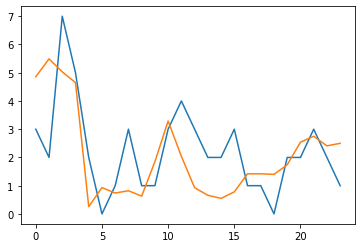

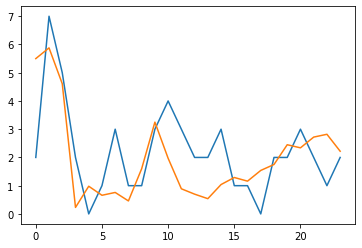

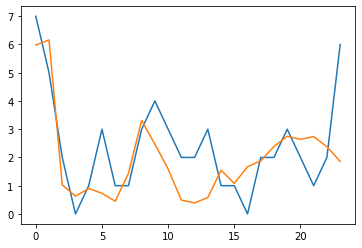

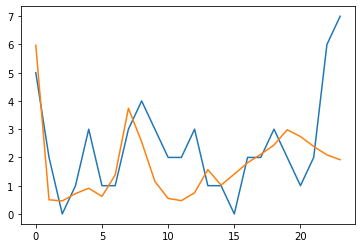

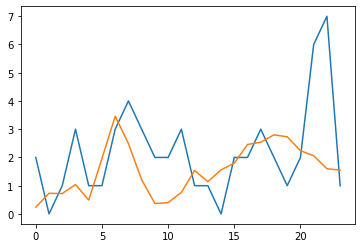

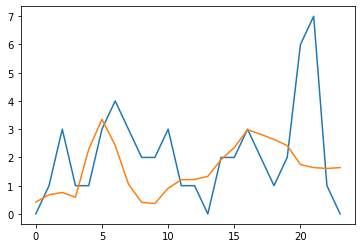

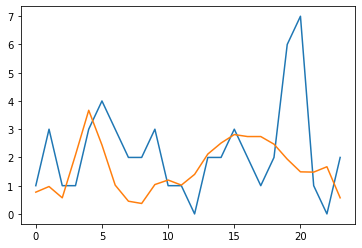

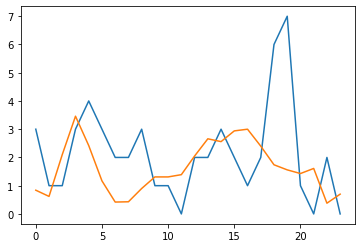

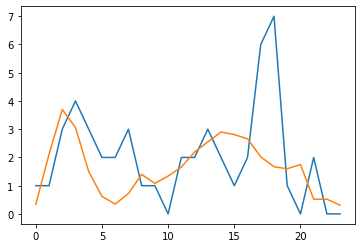

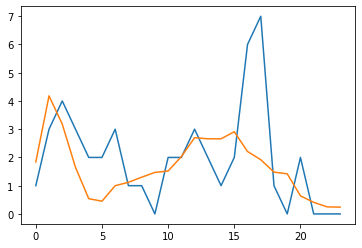

In [25]:
for i in range(len(actuals[-10:])):
  plt.plot(actuals[i])
  plt.plot(predictions[0][i])
  plt.show()

0      1916
1      1917
2      1918
3      1919
4      1920
       ... 
188    2104
189    2105
190    2106
191    2107
192    2108
Name: time_idx, Length: 193, dtype: int64


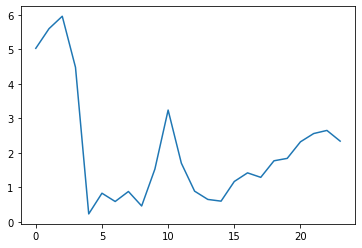

In [26]:
print(test_output[1]['time_idx'])

plt.plot(test_output[0][0])
plt.show()

In [27]:
print(len(df_175_test))

48


In [28]:
test_output[0][168]

tensor([1.3700, 3.7700, 4.9800, 5.8700, 1.1600, 0.5900, 0.7500, 0.7000, 0.4400,
        2.1500, 2.9700, 2.8000, 1.4700, 0.6400, 0.2400, 0.1000, 0.2700, 1.0200,
        1.8700, 1.7500, 2.1100, 2.9700, 3.3800, 2.7700])

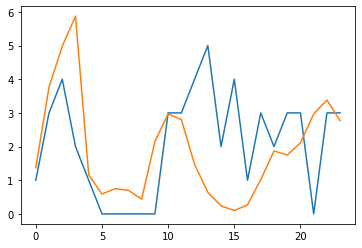

In [32]:
# test output.

plt.plot(df_175_train[2108:2132].values)
plt.plot(test_output[0][168])
plt.show()

In [30]:
traih_output = deepar.predict(data=train_dataloader,mode='prediction',return_index=True,num_workers=8,show_progress_bar=True)


Predict:   0%|          | 0/48 [00:00<?, ? batches/s]

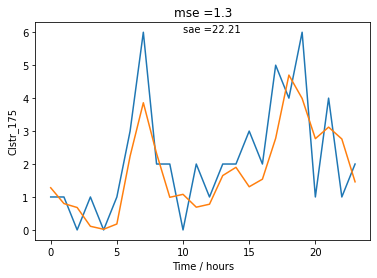

In [51]:
tru = df_175_train[1008:1032].values
pred = traih_output[0][1008]
plt.plot(tru)
plt.plot(pred)
plt.xlabel("Time / hours")
plt.ylabel("Clstr_175")

e= tru - np.array(pred)

sbe = 'sae =' +  str(round(sum(abs(e)),2))

mse = 'mse =' + str(round(np.mean(e**2),3)) 
plt.text(10, 6, sbe)
plt.title(mse)
plt.show()

30

In [8]:
from itertools import product

columns = ['temp_clstr_175', 'hum_clstr_175', 'wind_clstr_175', 'wea_clstr_175',
       'wea_desc_clstr_175', 'clstr_171', 'clstr_168']

hparams_grid = {"LSTM_neuron_size":[168,240,320],
	            "num_layers":[2],
                "batch_size":[2,4],
                "learning_rate":[0.001],
                "max_encoder_length":[168],
                "max_prediction_length":[24],
                "dropout":[0.2],
	            "Num_epochs":[20],
                "df_cov1":list(columns),
                "df_cov2":list(columns)}



ver=0
ver_dict = {'param':[], 'ver':[]}
param_comb_cnt=0
for neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2 in product(*[x for x in hparams_grid.values()]):
    #print(param_comb_cnt,neu,lay,bat,lr,enc_len,pred_len,drop,num_ep,df_cov_col1,df_cov_col2)
    param_comb_cnt+=1
    if df_cov_col1 == df_cov_col2:
        print('same col')
    else:
        ver_dict['param'].append(param_comb_cnt)
        ver_dict['ver'].append(ver)
        ver+=1

    

param_comb_cnt

for i in range(292):
    print(ver_dict['param'][i],ver_dict['ver'][i] )

same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
same col
1 0
2 1
3 2
4 3
5 4
6 5
7 6
9 7
10 8
11 9
12 10
13 11
14 12
15 13
17 14
18 15
19 16
20 17
21 18
22 19
23 20
25 21
26 22
27 23
28 24
29 25
30 26
31 27
33 28
34 29
35 30
36 31
37 32
38 33
39 34
41 35
42 36
43 37
44 38
45 39
46 40
47 41
50 42
51 43
52 44
53 45
54 46
55 47
56 48
58 49
59 50
60 51
61 52
62 53
63 54
64 55
66 56
67 57
68 58
69 59
70 60
71 61
72 62
74 63
75 64
76 65
77 66
78 67
79 68
80 69
82 70
83 71
84 72
85 73
86 74
87 75
88 76
90 77
91 78
92 79
93 80
94 81
95 82
96 83
99 84
100 85
101 86
102 87
103 88
104 89
105 90
107 91
108 92
109 93
110 94
111 95
112 96
113 97
115 98
116 99
117 100
118 101
119 102
1

IndexError: list index out of range

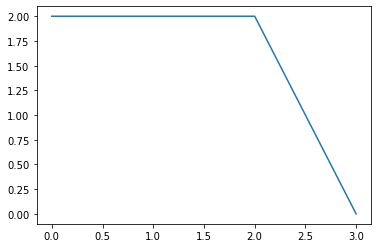

[0 2 2 2]
[3 0 1 2]


1.5811388300841898

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

pred=np.array([1,3,4,1])
actual = np.random.randint(low=0,high=5,size=4)
actual = actual

plt.plot(actual)
plt.show()

peak = np.sort(actual)
peak_idx = np.argsort(actual)

print(peak)
print(peak_idx)



rmse = np.sqrt ( mean_squared_error( actual[peak_idx[-2:]] , pred[peak_idx[-2:]]))
rmse